In [3]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [4]:
df = pd.read_csv('/home/kristina/code/g0zzy/stress_sense/raw_data/CombinedData.csv', index_col=0)

In [5]:
def get_df_info(df):
    print("\n\033[1mShape of DataFrame:\033[0m ", df.shape)
    print("\n\033[1mColumns in DataFrame:\033[0m ", df.columns.to_list())
    print("\n\033[1mData types of columns:\033[0m\n", df.dtypes)

    print("\n\033[1mInformation about DataFrame:\033[0m")
    df.info()

    print("\n\033[1mNumber of unique values in each column:\033[0m")
    for col in df.columns:
        print(f"\033[1m{col}\033[0m: {df[col].nunique()}")

    print("\n\033[1mNumber of null values in each column:\033[0m\n", df.isnull().sum())

    print("\n\033[1mNumber of duplicate rows:\033[0m ", df.duplicated().sum())

    print("\n\033[1mDescriptive statistics of DataFrame:\033[0m\n",)

    return df.describe().transpose()


In [22]:
get_df_info(df)


Shape of DataFrame:  (53043, 2)

Columns in DataFrame:  ['statement', 'status']

Data types of columns:
 statement    object
status       object
dtype: object

Information about DataFrame:
<class 'pandas.core.frame.DataFrame'>
Index: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB

Number of unique values in each column:
statement: 51073
status: 7

Number of null values in each column:
 statement    362
status         0
dtype: int64

Number of duplicate rows:  1944

Descriptive statistics of DataFrame:



,count,unique,top,freq
statement,52681,51073,what do you mean?,22
status,53043,7,Normal,16351


In [6]:
df['status'].value_counts()

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64

In [24]:
# Keep only stress-like categories
df = df[df['status'].isin(['Stress','Anxiety','Normal'])]
df['status'].value_counts()

status
Normal     16351
Anxiety     3888
Stress      2669
Name: count, dtype: int64

In [25]:
df.dropna(inplace=True)

In [ ]:
# Map string labels to integers
label_mapping = {label: i for i, label in enumerate(df['status'].unique())}

df['label'] = df['status'].map(label_mapping)


np.int64(0)

In [49]:
# Split data into training and validation sets
train_text, val_text, train_labels, val_labels = train_test_split(df['statement'], df['status'], random_state=42, test_size=0.2)


In [50]:
# Convert train_labels and val_labels to lists
train_labels = train_labels.tolist()
val_labels = val_labels.tolist()

In [51]:
# Create a custom dataset class
class MentalHealthDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [14]:
# Load tokenizer and model with revised configuration
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', clean_up_tokenization_spaces=True)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [53]:
# Tokenize text
train_encodings = tokenizer(list(train_text), truncation=True, padding=True)
val_encodings = tokenizer(list(val_text), truncation=True, padding=True)

In [54]:
# Create dataset instances
train_dataset = MentalHealthDataset(train_encodings, train_labels)
val_dataset = MentalHealthDataset(val_encodings, val_labels)

In [55]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [15]:
# Define device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [16]:
# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

In [59]:
# Evaluate model
def evaluate_model(model, loader, device):
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_loss = 0
        count = 0
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            count += 1

            _, predicted = torch.max(outputs.logits, dim=1)
            total_correct += (predicted == labels).sum().item()
        accuracy = total_correct / len(loader.dataset)
        average_loss = total_loss / count
        return accuracy, average_loss


# Train model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    train_accuracy, _ = evaluate_model(model, train_loader, device)
    train_accuracies.append(train_accuracy)

    model.eval()
    val_accuracy, val_loss = evaluate_model(model, val_loader, device)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    print(f'Train Accuracy: {train_accuracies[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')

Epoch 1, Train Loss: 0.2892, Val Loss: 0.1759
Train Accuracy: 0.9465, Val Accuracy: 0.9306
Epoch 2, Train Loss: 0.1219, Val Loss: 0.1230
Train Accuracy: 0.9849, Val Accuracy: 0.9574
Epoch 3, Train Loss: 0.0700, Val Loss: 0.1362
Train Accuracy: 0.9930, Val Accuracy: 0.9559
Epoch 4, Train Loss: 0.0350, Val Loss: 0.1772
Train Accuracy: 0.9959, Val Accuracy: 0.9493
Epoch 5, Train Loss: 0.0218, Val Loss: 0.1737
Train Accuracy: 0.9980, Val Accuracy: 0.9568


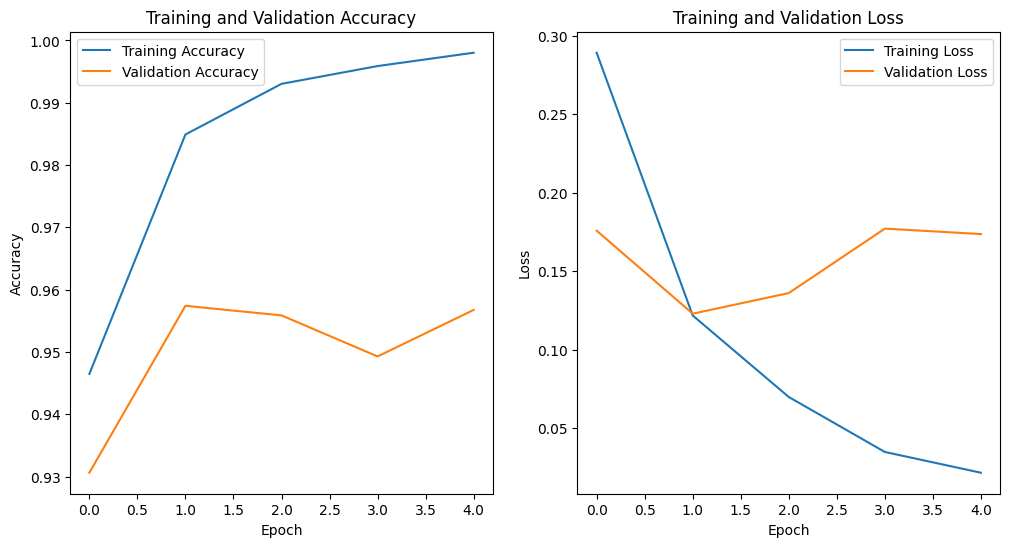

In [60]:
# Plot training and validation accuracy and losses
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [61]:
# Classification report and Confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

model.eval()
with torch.no_grad():
    predictions = []
    labels = []
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        batch_labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        _, predicted = torch.max(outputs.logits, dim=1)
        predictions.extend(predicted.cpu().numpy())
        labels.extend(batch_labels.cpu().numpy())

print(classification_report(labels, predictions))
print(confusion_matrix(labels, predictions))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       752
           1       0.99      0.97      0.98      3320
           2       0.79      0.90      0.84       483

    accuracy                           0.96      4555
   macro avg       0.91      0.94      0.92      4555
weighted avg       0.96      0.96      0.96      4555

[[ 716   12   24]
 [  21 3208   91]
 [  26   23  434]]


In [ ]:
#Save model
model.save_pretrained('/home/kristina/code/g0zzy/stress_sense/models/dlbert')
tokenizer.save_pretrained('/home/kristina/code/g0zzy/stress_sense/models/dlbert')


In [5]:
# Create a function to get predictions from the model
def get_prediction(text, model, tokenizer, device):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    outputs = model(**inputs)
    _, predicted = torch.max(outputs.logits, dim=1)
    return predicted.item()

In [6]:
test_texts = [
    "I've been feeling overwhelmed with work lately, but I'm trying to stay positive.",
    "Sometimes I wonder if life is worth living, but I don't know what's holding me back.",
    "I'm exhausted from pretending to be okay, but I'm scared of what others might think.",
    "I've been experiencing mood swings, and I don't know how to control them.",
    "I feel like I'm losing grip on reality, but I'm trying to hold on.",
    "I'm struggling to concentrate, and my mind keeps racing.",
    "I've been having trouble sleeping, and I feel anxious all the time.",
    "I feel like I'm stuck in a rut, and I don't know how to get out.",
    "Sometimes I feel like I'm two different people, and I don't know which one is real.",
    "I've been experiencing flashbacks, and I don't know how to make them stop."
]

In [7]:
class_labels = {
    0: 'Anxiety',
    1: 'Normal',
    2: 'Stress',
}

In [ ]:
# Get predictions for test texts
for text in test_texts:
    predicted_class = get_prediction(text, model, tokenizer, device)
    print(f'Text: {text}')
    print(f'Predicted Class: {class_labels[predicted_class]}')
    print(predicted_class)
    print('---')

In [1]:
#Load model
from transformers import AutoModelForSequenceClassification, AutoTokenizer

#Load the model and tokenizer from the saved paths
model_loaded = AutoModelForSequenceClassification.from_pretrained('/home/kristina/code/g0zzy/stress_sense/models/dlbert')
tokenizer_loaded = AutoTokenizer.from_pretrained('/home/kristina/code/g0zzy/stress_sense/models/dlbert')


/home/kristina/.pyenv/versions/3.10.6/envs/stress_sense/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# Get predictions for test texts from the loaded model
for text in test_texts:
    predicted_class = get_prediction(text, model_loaded, tokenizer_loaded, device)
    print(f'Text: {text}')
    print(f'Predicted Class: {class_labels[predicted_class]}')
    print('---')

Text: I've been feeling overwhelmed with work lately, but I'm trying to stay positive.
Predicted Class: Stress
---
Text: Sometimes I wonder if life is worth living, but I don't know what's holding me back.
Predicted Class: Stress
---
Text: I'm exhausted from pretending to be okay, but I'm scared of what others might think.
Predicted Class: Stress
---
Text: I've been experiencing mood swings, and I don't know how to control them.
Predicted Class: Stress
---
Text: I feel like I'm losing grip on reality, but I'm trying to hold on.
Predicted Class: Stress
---
Text: I'm struggling to concentrate, and my mind keeps racing.
Predicted Class: Stress
---
Text: I've been having trouble sleeping, and I feel anxious all the time.
Predicted Class: Anxiety
---
Text: I feel like I'm stuck in a rut, and I don't know how to get out.
Predicted Class: Stress
---
Text: Sometimes I feel like I'm two different people, and I don't know which one is real.
Predicted Class: Normal
---
Text: I've been experiencin